# PIK3CA: Effects of Mutation on BACH2

<b> Standard imports for playing with and plotting data frames. </b>

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import re
import statsmodels.stats.multitest

<b> Import CPTAC data </b>

In [2]:
import CPTAC

Loading CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter CPTAC.embargo() to open the webpage for more details.


In [3]:
somatic_mutations = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

# PI3KCA mutation and BACH2 proteome abundance 

### Perform a t-test with mutated and non-mutated protein levels

In [7]:
protList = ['BACH2']
pcutoff = 0.05 / len(protList)
gene = 'PIK3CA'

proteomics = proteomics[:100]

sigResults = [];
for protein in protList: 
    if protein in proteomics.columns:
        cross = CPTAC.compare_mutations(proteomics, protein, gene)
        cross = cross[["Mutation", protein]].dropna(axis=0)
        mutated = cross.loc[cross["Mutation"] == "Missense_Mutation"]
        wt = cross.loc[cross["Mutation"] == "Wildtype"]
        ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
        if(ttest[1] <= pcutoff):
            sigResults.append(protein)
            print("Test for " + protein + ": ")
            print(ttest) 
print(cross)

NameError: name 'cross' is not defined

 ### We can now plot the data 

NameError: name 'cross' is not defined

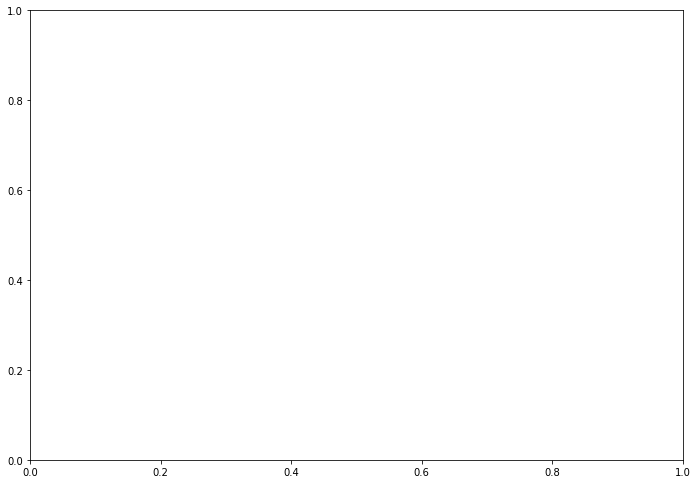

In [5]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
somatic_boxplot = sns.boxplot(data=cross, x="Mutation",y=protein, ax = ax)
somatic_boxplot.set_title("PI3KCA gene mutation BACH protein abundance")
somatic_boxplot = sns.stripplot(data=cross, x="Mutation", y=protein,jitter=True, color=".3")
somatic_boxplot.set(xlabel="Somatic Gene Mutation",ylabel="Proteomics")
plt.show()

# PI3KCA mutation and BACH2 phosphoproteome abundance 

In [9]:
sites = phos.columns
p_values = []
site_names = []
protein = 'BACH2'


pattern = re.compile(protein)
isInList = filter(pattern.search, sites)
if next(isInList, None) is not None:
    phosphositesdf = CPTAC.compare_mutations(phos, protein, gene)
    phosphositesdf = phosphositesdf.loc[phosphositesdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1)
    for site in phosphositesdf.columns:
        if (site is not 'Mutation'):
            sitedf = CPTAC.compare_mutations(phos, site, gene)
            mutateddf = sitedf.loc[sitedf['Mutation'] != 'Wildtype'].dropna(axis=0)
            wtdf = sitedf.loc[sitedf['Mutation'] == 'Wildtype'].dropna(axis=0)
            ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
            p_values.append(ttest[1])
            print(site, p_values)
            site_names.append(site)     
                
#We need to remove all 'nan' p-values and their corresponding site names before passing it in for the fdr correction
indexesToRemove=[]

for index in range(0, len(p_values)):
    if np.isnan(p_values[index]):
        indexesToRemove.append(index)

for rem in range( len(indexesToRemove)-1, -1, -1):
    p_values.pop(indexesToRemove[rem])
    site_names.pop(indexesToRemove[rem])
#p_values and site names have now had all entries removed where the corresponding p-value is 'nan'
        

pvalues = statsmodels.stats.multitest.fdrcorrection(p_values,alpha=0.05, method='indep')[1] 
print("Adjusted p values: " + str(pvalues))
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_values,alpha=0.05, method='indep')[0]


significant_sites = np.array(site_names)[np.array(areSignificant)]
significant_pvalues = np.array(pvalues)[np.array(areSignificant)]

significant_vals = dict(zip(significant_sites, significant_pvalues))

print(significant_sites)
print(significant_pvalues)
print(significant_vals)

BACH2-S159 [0.0007258474866574831]
BACH2-S315 [0.0007258474866574831, 0.43612966470634973]
BACH2-S337 [0.0007258474866574831, 0.43612966470634973, 0.09291752758989662]
BACH2-S367 [0.0007258474866574831, 0.43612966470634973, 0.09291752758989662, nan]
BACH2-S409 [0.0007258474866574831, 0.43612966470634973, 0.09291752758989662, nan, 0.7471180768608647]
BACH2-S510 [0.0007258474866574831, 0.43612966470634973, 0.09291752758989662, nan, 0.7471180768608647, 0.00286270135944502]
BACH2-T319 [0.0007258474866574831, 0.43612966470634973, 0.09291752758989662, nan, 0.7471180768608647, 0.00286270135944502, 0.6594532216068147]
Adjusted p values: [0.00435508 0.6541945  0.18583506 0.74711808 0.0085881  0.74711808]
['BACH2-S159' 'BACH2-S510']
[0.00435508 0.0085881 ]
{'BACH2-S159': 0.004355084919944899, 'BACH2-S510': 0.00858810407833506}


In [ ]:
phosdf = CPTAC.compare_mutations(phos, protein, gene)

phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor']

## Plot all of the phosphoproteomic measurements

In [ ]:
protein = 'BACH2'
gene = 'PIK3CA'
phosdf = CPTAC.compare_mutations(phos, protein, gene)
#print(phosdf)
phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis=1)

In [ ]:
phosdf.loc[(phosdf['Mutation'] == "Wildtype"), "Mutation"] = "Control"
phosdf.loc[(phosdf['Mutation'] != "Control"), "Mutation"] = "Mutated"

phosdf = pd.melt(phosdf, id_vars=['Mutation'], var_name='Type', value_name='Reading')
phosdf = phosdf.loc[(phosdf["Mutation"] == "Control") | (phosdf["Mutation"] == "Mutated")]
phosdf = phosdf.dropna(axis=0).sort_values(by=['Mutation'], ascending=False)
#phosdf = phosdf.loc[(phosdf['Type'] == significant_sites)]
plotdf = None

In [ ]:
#interested_sites = ['IRS1-S1100', 'IRS1-S1101', 'IRS1-S1133', 'IRS1-S672', 'IRS1-S766']
for site in significant_sites:
    tempdf = phosdf.loc[(phosdf['Type'] == site)]
    print(tempdf)
    if plotdf is None:
        plotdf = tempdf
    else:
        plotdf = plotdf.append(tempdf)
        
print(plotdf)

In [ ]:
a4_dims = (40.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Mutated": "#009933", "Control": "#008ae6"}

#Create the plot
boxplt = sns.boxplot(x='Type', y='Reading', hue='Mutation', data=plotdf, palette=my_pal)
boxplt = sns.stripplot(data=plotdf, x='Type', y='Reading', hue='Mutation', dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_ylabel('Signal', fontsize='30')
boxplt.tick_params(labelsize='20')

#Adjust legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Mutated', 'Control'], title='BACH2 Status', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('20')
#boxplt.get_legend().set_bbox_to_anchor((1, 1, 0, 0))


fig = boxplt.get_figure()
plt.show()